In [1]:
#Importing necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report 
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import seaborn as sns

import numpy as np
import pandas as pd

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import random as rn
import re

In [2]:
seed_value = 1337
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
rn.seed(seed_value)

In [15]:
data = pd.read_csv('../Data/tripadvisor_hotel_reviews.csv')
data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [4]:
class_dist = data['Rating'].value_counts()

def distribution_plot(x, y, name):
    fig = go.Figure([
        go.Bar(x=x,y=y)
    ])
    fig.update_layout(title_text=name)
    fig.show()

In [5]:
distribution_plot(x = class_dist.index, y = class_dist.values,name = 'Class Distribution')

In [6]:
def wordCloud_generator(data, title = None):
    wordcloud = WordCloud(width = 800, height =800,
                          background_color = 'black',
                          min_font_size = 10
    ).generate(" ".join(data.values)) 

    #Plot the WordCloud image
    plt.figure(figsize = (8,8), facecolor = None)
    plt.imshow(wordcloud,interpolation = 'bilinear')
    plt.axis("off")
    plt.tight_layout(pad =0)
    plt.title(title, fontsize=30)
    plt.show()


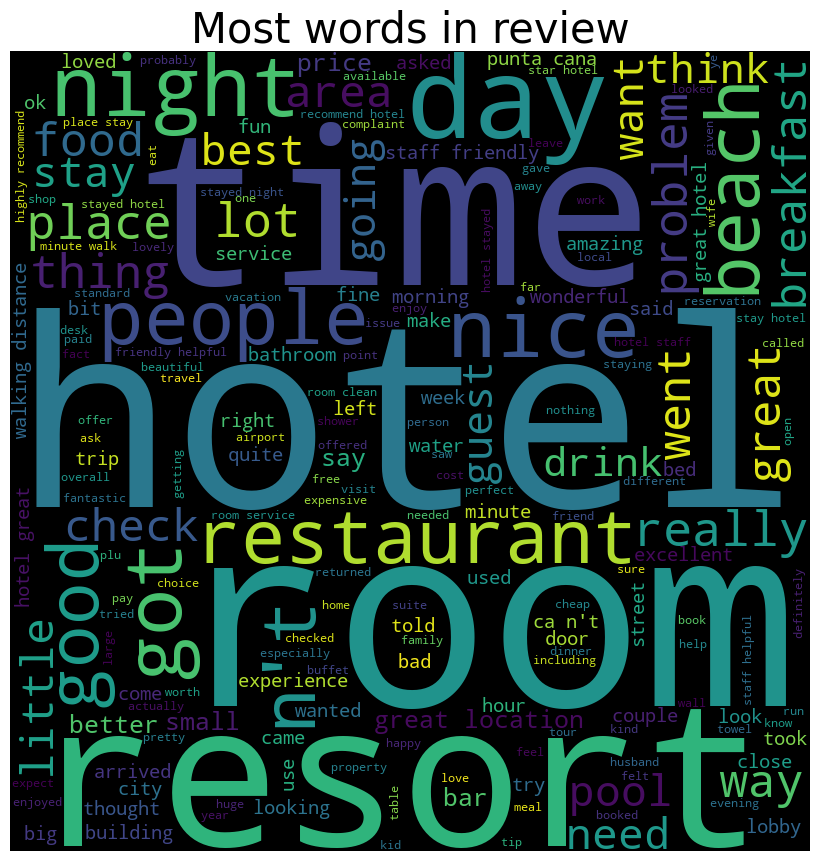

In [7]:
wordCloud_generator(data['Review'], title="Most words in review")

# Data preprocessing

In [25]:
X = data['Review'].copy()
y = data['Rating'].copy()

Cleaning

In [26]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AkshitaGadhiraju\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
ps = PorterStemmer()
stop_words = stopwords.words('english')

In [28]:
def data_cleaner(review):
    #remove digits
    review = re.sub(r'\d+',' ',review)

    #removing stop words
    review = review.split()
    review = " ".join([word for word in review if not word in stop_words])

    #Stemming
    #review = " ".join([ps.stem(w) for w in review])

    return review



In [29]:
X_cleaned = X.apply(data_cleaner)
X_cleaned.head()

0    nice hotel expensive parking got good deal sta...
1    ok nothing special charge diamond member hilto...
2    nice rooms * experience hotel monaco seattle g...
3    unique, great stay, wonderful time hotel monac...
4    great stay great stay, went seahawk game aweso...
Name: Review, dtype: object

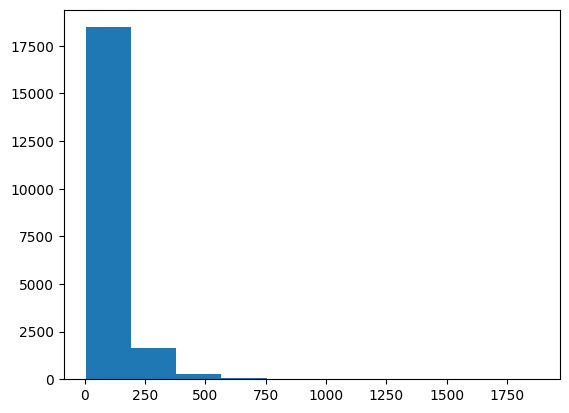

In [30]:
length_dist = [len(x.split(" ")) for x in X_cleaned]
plt.hist(length_dist)
plt.show()

Tokenizing

In [31]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_cleaned)

X = tokenizer.texts_to_sequences(X_cleaned)

max_length = max([len(x) for x in X])
vocab_size = len(tokenizer.word_index) + 1
exp_sen = 1

print("Vocabulary size:{}". format(vocab_size))
print("Max length of sentence: {}" . format(max_length))
print("\nExample:\n")
print("Sentence: \n{}" . format(X_cleaned[exp_sen]))
print("\nAfter Tokenization: \n{}" . format(X[exp_sen]))

X = pad_sequences(X, padding='post', maxlen=350)
print("After Padding: \n{}" . format(X[exp_sen]))


Vocabulary size:49536
Max length of sentence: 1940

Example:

Sentence: 
ok nothing special charge diamond member hilton decided chain shot th anniversary seattle, start booked suite paid extra website description not, suite bedroom bathroom standard hotel room, took printed reservation desk showed said things like tv couch ect desk clerk told oh mixed suites description kimpton website sorry free breakfast, got kidding, embassy suits sitting room bathroom bedroom unlike kimpton calls suite, day stay offer correct false advertising, send kimpton preferred guest website email asking failure provide suite advertised website reservation description furnished hard copy reservation printout website desk manager duty reply solution, send email trip guest survey follow email mail, guess tell concerned guest.the staff ranged indifferent helpful, asked desk good breakfast spots neighborhood hood told hotels, gee best breakfast spots seattle / block away convenient hotel know exist, arrived late

Encoding

In [33]:
encoding = {
    1:0,
    2:1,
    3:2,
    4:3,
    5:4
}

labels = ['1' , '2' , '3' , '4' , '5' ]

y.replace(encoding, inplace=True)

Split data into train/test

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size = 0.33, stratify=y
)

Model building and training

In [51]:
# hyper parameters
EPOCHS = 3
BATCH_SIZE = 100
embedding_dim = 16
units = 76

model = tf.keras.Sequential([
    L.Input(shape=(X.shape[1],)),
    L.Embedding(vocab_size, embedding_dim),
    L.Bidirectional(L.LSTM(units,return_sequences=True)),
    #L.LSTM(units,return_sequences=True),
    L.Conv1D(64,3),
    L.MaxPool1D(),
    L.Flatten(),
    L.Dropout(0.5),
    L.Dense(128, activation="relu"),
    L.Dropout(0.5),
    L.Dense(64, activation="relu"),
    L.Dropout(0.5),
    L.Dense(5, activation="softmax")
])

model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer='adam',metrics=['accuracy']
             )

model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 350, 16)        │       792,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 350, 152)       │        56,544 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 348, 64)        │        29,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 174, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 11136)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 11136)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │     1,425,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,312,485 (8.82 MB)

 Trainable params: 2,312,485 (8.82 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_split=0.12, batch_size=BATCH_SIZE, verbose=2)


Epoch 1/3
121/121 - 66s - 549ms/step - accuracy: 0.4414 - loss: 1.2809 - val_accuracy: 0.5188 - val_loss: 0.9858
Epoch 2/3
121/121 - 52s - 429ms/step - accuracy: 0.5532 - loss: 0.9688 - val_accuracy: 0.6056 - val_loss: 0.8973
Epoch 3/3
121/121 - 49s - 402ms/step - accuracy: 0.6508 - loss: 0.7967 - val_accuracy: 0.6038 - val_loss: 0.9329


Training history

In [58]:
fig = px.line(
    history.history, y=['accuracy', 'val_accuracy'],
    labels={'index':'epoch', 'value':'accuracy'}
)

fig.show()

In [59]:
fig = px.line(
    history.history, y=['loss', 'val_loss'],
    labels={'index': 'epoch', 'value': 'loss'}
)

fig.show()

Evaluation

In [70]:
pred = model.predict(X_test)
predicted_classes = np.argmax(pred, axis=-1)


212/212 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step


In [71]:
predicted_classes

array([4, 4, 4, ..., 0, 4, 3], shape=(6763,))

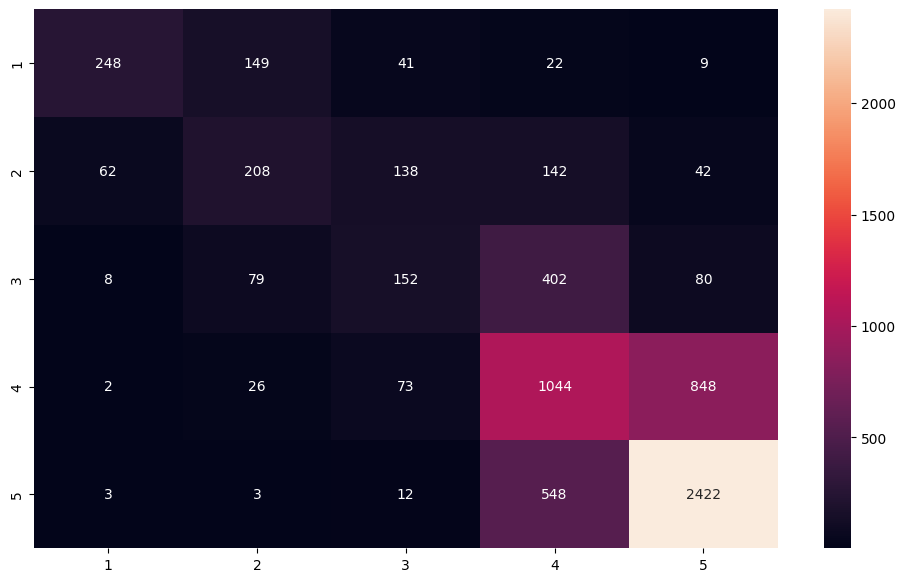

In [72]:
conf = confusion_matrix(y_test, predicted_classes)

cm = pd.DataFrame(
    conf, index = [i for i in labels],
    columns = [i for i in labels]
)

plt.figure(figsize = (12,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

In [74]:
print('Accuracy:', accuracy_score(y_test,predicted_classes))

Accuracy: 0.6023953866627236


In [76]:
print("Mean absolute error:",mean_absolute_error(predicted_classes,y_test))

Mean absolute error: 0.4690226230962591


In [79]:
print("Root mean square error:",np.sqrt(mean_squared_error(predicted_classes,y_test)))

Root mean square error: 0.8018166568518558


Classification Report

In [81]:
print(classification_report(y_test, predicted_classes, target_names=labels))

              precision    recall  f1-score   support

           1       0.77      0.53      0.63       469
           2       0.45      0.35      0.39       592
           3       0.37      0.21      0.27       721
           4       0.48      0.52      0.50      1993
           5       0.71      0.81      0.76      2988

    accuracy                           0.60      6763
   macro avg       0.56      0.49      0.51      6763
weighted avg       0.59      0.60      0.59      6763

